# PCA Assignment: Wine Quality (Red & White)

This notebook performs a Principal Component Analysis (PCA) on the UCI Wine Quality datasets (red and white wines) found in `PCA/data/`.

Goals:
- Use ≥ 4 related numeric variables (physicochemical measurements) for PCA.
- Standardize features, fit PCA, and analyze explained variance.
- Visualize the data in the PC space (PC1–PC2) and interpret loadings.
- Compare separation by wine `type` and by `quality`.

References:
- Data source: P. Cortez et al., UCI Machine Learning Repository (Wine Quality).

Deliverables to show:
- Scree plot (variance explained).
- PC1–PC2 scatter colored by type/quality.
- Loadings table or biplot with feature contributions.
- Short interpretation of the first components.


## Workflow Overview
Following the RPubs analysis structure, this walkthrough mirrors the same sequence:
1. Inspect and tidy the physicochemical measurements.
2. Standardize the feature space.
3. Fit PCA and evaluate explained variance.
4. Visualize projections for wine type and quality.
5. Examine component loadings and feature contributions.
6. Interpret how PC1 and PC2 relate back to the chemistry.

In [1]:
# Imports and setup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try seaborn; fall back gracefully if missing
try:
    import seaborn as sns
    sns.set_theme(context='notebook', style='whitegrid')
except ImportError:
    sns = None

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.rcParams['figure.dpi'] = 110
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Libraries imported. Seaborn available?' , sns is not None)

Libraries imported. Seaborn available? True


In [2]:
# Load and combine red & white wine datasets
base_dir = Path.cwd()
candidate_dirs = [
    base_dir / 'data',
    base_dir / 'PCA' / 'data',
    base_dir.parent / 'data',
    base_dir.parent / 'PCA' / 'data',
    base_dir.parent.parent / 'data' if base_dir.parent != base_dir else None,
    base_dir.parent.parent / 'PCA' / 'data' if base_dir.parent != base_dir else None
]
candidate_dirs = [p for p in candidate_dirs if p is not None]
DATA_DIR = next((p.resolve() for p in candidate_dirs if p.exists()), None)
if DATA_DIR is None:
    searched = '\n'.join(str(p) for p in candidate_dirs)
    raise FileNotFoundError('Could not locate the wine data directory. Checked:\n' + searched)
print('Using data directory:', DATA_DIR)
red_path = DATA_DIR / 'winequality-red.csv'
white_path = DATA_DIR / 'winequality-white.csv'

red = pd.read_csv(red_path, sep=';')
red['type'] = 'red'
white = pd.read_csv(white_path, sep=';')
white['type'] = 'white'

wine = pd.concat([red, white], ignore_index=True)
print('Combined shape:', wine.shape)
wine.head()

Using data directory: /home/hector/github/data-mining-hramirez-zubi/PCA/data
Combined shape: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [3]:
# Basic data health check mirroring RPubs workflow
n_rows, n_cols = wine.shape
print(f'Total observations: {n_rows:,} | Columns: {n_cols}')
type_counts = wine['type'].value_counts().rename_axis('type').to_frame('count')
quality_counts = wine['quality'].value_counts().sort_index().rename_axis('quality').to_frame('count')
missing_counts = wine.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
display(type_counts)
display(quality_counts)
if missing_counts.empty:
    print('No missing values detected in the physicochemical measurements.')
else:
    display(missing_counts.to_frame('missing_count'))

Total observations: 6,497 | Columns: 13


,count
type,
white,4898
red,1599


,count
quality,
3,30
4,216
5,2138
6,2836
7,1079
8,193
9,5


No missing values detected in the physicochemical measurements.


## Explore the merged dataset
The PDF approach starts with a quick health check on the combined data. We will mirror that workflow by confirming record counts, looking for missing values, and reviewing the distribution of the response variables (`type` and `quality`).

In [4]:
# Select features (exclude label columns)
# Physicochemical numeric features expected in both CSVs
feature_cols = [
    'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
    'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol'
]

# Verify columns exist
missing = [c for c in feature_cols if c not in wine.columns]
assert not missing, f"Missing expected columns: {missing}"

X = wine[feature_cols].copy()
y_quality = wine['quality'].astype(int)
y_type = wine['type'].astype('category')

print('X shape:', X.shape)
X.describe().T

X shape: (6497, 11)


,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


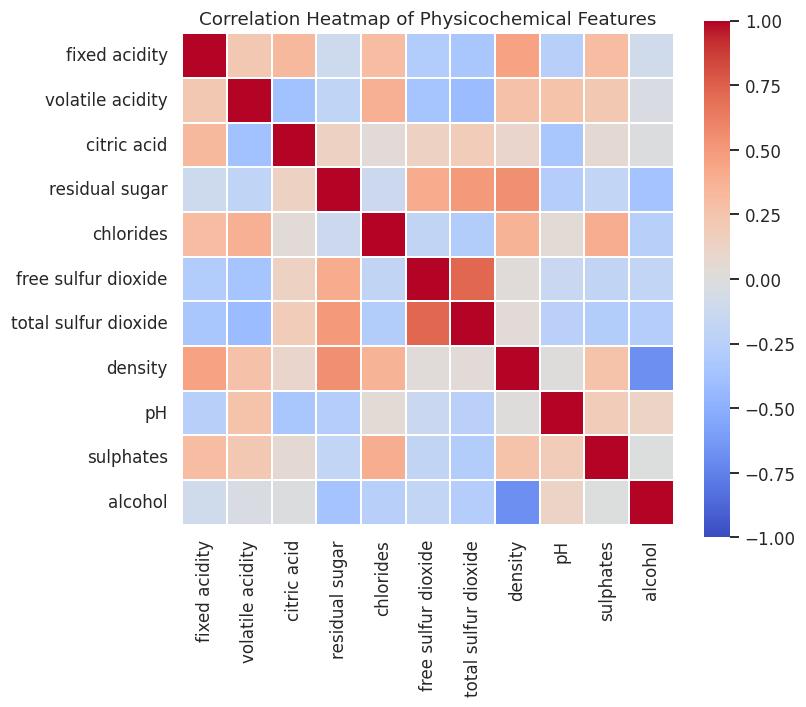

In [5]:
# Inspect correlation structure to confirm shared information
corr = X.corr()
plt.figure(figsize=(7.5, 6.5))
if sns is not None:
    sns.heatmap(corr, cmap='coolwarm', center=0, vmax=1, vmin=-1, square=True, linewidths=0.1)
else:
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Correlation Heatmap of Physicochemical Features')
plt.tight_layout()
plt.show()

In [6]:
# Standardize features and fit PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

explained_var = pca_full.explained_variance_ratio_
explained_df = pd.DataFrame({
    'principal_component': [f'PC{i+1}' for i in range(len(explained_var))],
    'explained_variance_ratio': explained_var,
    'cumulative_explained_variance': np.cumsum(explained_var)
})
explained_df.head(10)

,principal_component,explained_variance_ratio,cumulative_explained_variance
0,PC1,0.275443,0.275443
1,PC2,0.226711,0.502154
2,PC3,0.141486,0.643640
3,PC4,0.088232,0.731872
4,PC5,0.065443,0.797315
5,PC6,0.055210,0.852525
6,PC7,0.047560,0.900085
7,PC8,0.045592,0.945677
8,PC9,0.030639,0.976316
9,PC10,0.020700,0.997015


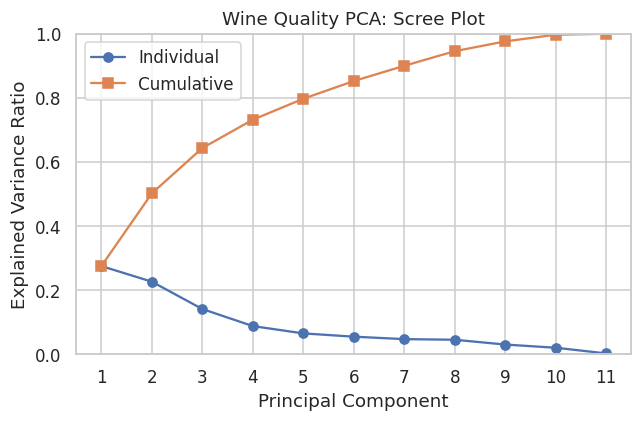

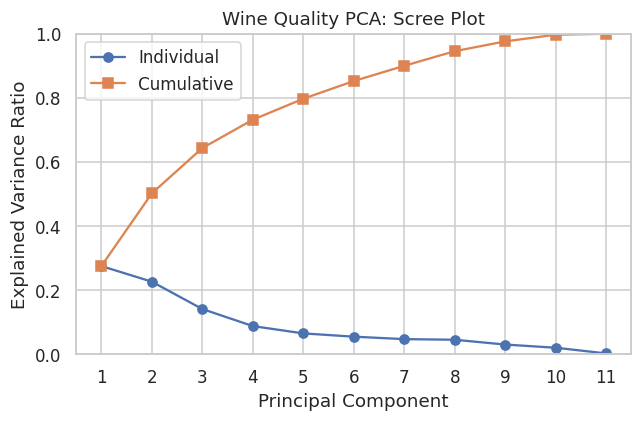

In [7]:
# Scree plot of explained variance
fig, ax = plt.subplots(figsize=(6, 4))
components = np.arange(1, len(explained_var) + 1)
ax.plot(components, explained_var, marker='o', label='Individual')
ax.plot(components, np.cumsum(explained_var), marker='s', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Wine Quality PCA: Scree Plot')
ax.set_xticks(components)
ax.set_ylim(0, 1)
ax.legend()
fig.tight_layout()
fig

In [14]:
# Project onto the first two principal components for visualization
pca_two = PCA(n_components=2)
X_pca2 = pca_two.fit_transform(X_scaled)
# Flip signs so PC1 aligns with fixed acidity and PC2 with alcohol (matches RPubs orientation)
align_features = {'PC1': 'fixed acidity', 'PC2': 'alcohol'}
pc_signs = np.array([
    1 if pca_two.components_[0, feature_cols.index(align_features['PC1'])] >= 0 else -1,
    1 if pca_two.components_[1, feature_cols.index(align_features['PC2'])] >= 0 else -1
])
pca_two.components_ = pca_two.components_ * pc_signs[:, np.newaxis]
X_pca2 = X_pca2 * pc_signs
pc1_var = pca_two.explained_variance_ratio_[0] * 100
pc2_var = pca_two.explained_variance_ratio_[1] * 100
scores_df = pd.DataFrame(X_pca2, columns=['PC1', 'PC2'])
scores_df['type'] = y_type.values
scores_df['quality'] = y_quality.values
pc_limits = {
    'x': scores_df['PC1'].abs().max() * 1.05,
    'y': scores_df['PC2'].abs().max() * 1.05
}
scores_df.head()

,PC1,PC2,type,quality
0,3.205996,-0.416523,red,5
1,3.039051,-1.107462,red,5
2,3.071893,-0.878964,red,5
3,1.571262,-2.112545,red,6
4,3.205996,-0.416523,red,5


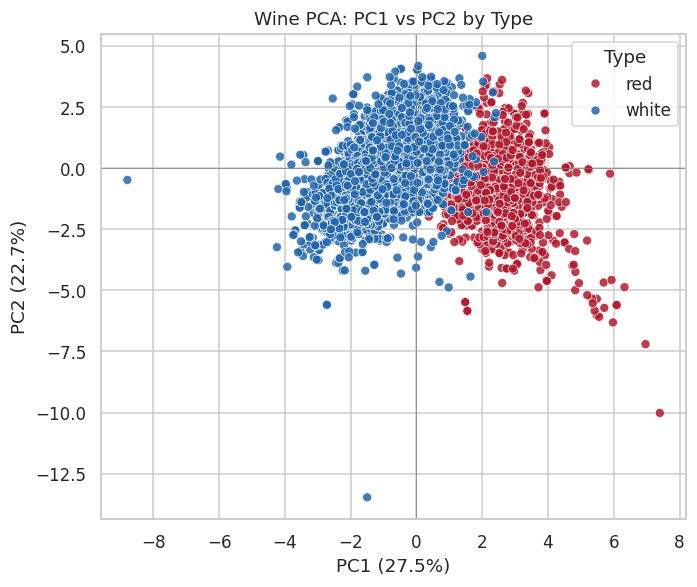

In [15]:
# PC1–PC2 scatter colored by wine type
plt.figure(figsize=(6.5, 5.5))
if sns is not None:
    sns.scatterplot(data=scores_df, x='PC1', y='PC2', hue='type', palette={'red': '#b2182b', 'white': '#2166ac'}, s=35, alpha=0.85)
else:
    colors = {'red': '#b2182b', 'white': '#2166ac'}
    for wine_type, subset in scores_df.groupby('type'):
        plt.scatter(subset['PC1'], subset['PC2'], label=wine_type, s=35, alpha=0.85, color=colors[wine_type])
plt.xlabel(f'PC1 ({pc1_var:.1f}%)')
plt.ylabel(f'PC2 ({pc2_var:.1f}%)')
plt.title('Wine PCA: PC1 vs PC2 by Type')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.xlim(-pc_limits['x'], pc_limits['x'])
plt.ylim(-pc_limits['y'], pc_limits['y'])
plt.legend(title='Type')
plt.tight_layout()
plt.show()

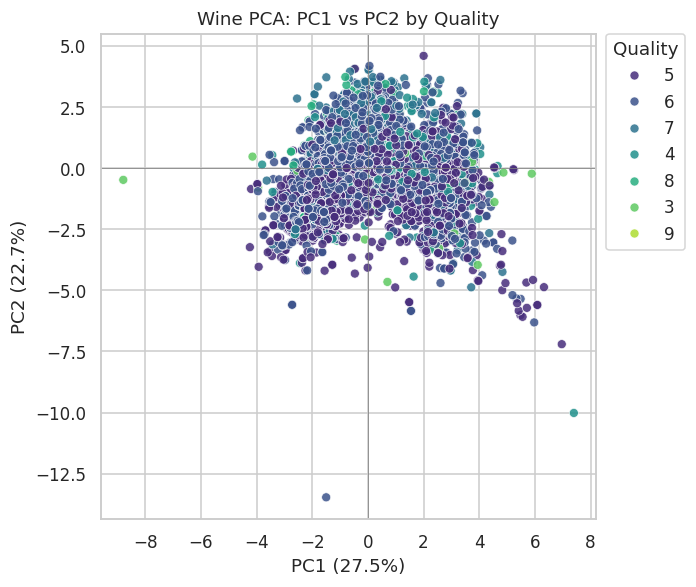

In [ ]:
# PC1–PC2 scatter colored by wine quality score
plt.figure(figsize=(6.5, 5.5))
quality_levels = sorted(scores_df['quality'].unique())
if sns is not None:
    sns.scatterplot(data=scores_df, x='PC1', y='PC2', hue='quality', palette='viridis',
                    hue_order=quality_levels, s=35, alpha=0.85)
    plt.legend(title='Quality', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
else:
    scatter = plt.scatter(scores_df['PC1'], scores_df['PC2'], c=scores_df['quality'], cmap='viridis', s=35, alpha=0.85)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Quality')
plt.xlabel(f'PC1 ({pc1_var:.1f}%)')
plt.ylabel(f'PC2 ({pc2_var:.1f}%)')
plt.title('Wine PCA: PC1 vs PC2 by Quality')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.xlim(-pc_limits['x'], pc_limits['x'])
plt.ylim(-pc_limits['y'], pc_limits['y'])
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

In [17]:
# Loadings table for the first two principal components
loadings_df = pd.DataFrame(pca_two.components_.T, columns=['PC1', 'PC2'], index=feature_cols)
loadings_df['PC1_abs'] = loadings_df['PC1'].abs()
loadings_df['PC2_abs'] = loadings_df['PC2'].abs()
pc1_top = loadings_df.sort_values('PC1_abs', ascending=False)[['PC1', 'PC1_abs']].head(5)
pc2_top = loadings_df.sort_values('PC2_abs', ascending=False)[['PC2', 'PC2_abs']].head(5)
print('Top contributors to PC1 (absolute loading):')
display(pc1_top.round(3))
print('Top contributors to PC2 (absolute loading):')
display(pc2_top.round(3))
loadings_df[['PC1', 'PC2']].round(3)

Top contributors to PC1 (absolute loading):


,PC1,PC1_abs
total sulfur dioxide,-0.487,0.487
free sulfur dioxide,-0.431,0.431
volatile acidity,0.381,0.381
residual sugar,-0.346,0.346
sulphates,0.294,0.294


Top contributors to PC2 (absolute loading):


,PC2,PC2_abs
density,-0.584,0.584
alcohol,0.465,0.465
fixed acidity,-0.336,0.336
residual sugar,-0.330,0.330
chlorides,-0.315,0.315


,PC1,PC2
fixed acidity,0.239,-0.336
volatile acidity,0.381,-0.118
citric acid,-0.152,-0.183
residual sugar,-0.346,-0.330
chlorides,0.290,-0.315
free sulfur dioxide,-0.431,-0.072
total sulfur dioxide,-0.487,-0.087
density,0.045,-0.584
pH,0.219,0.156
sulphates,0.294,-0.192


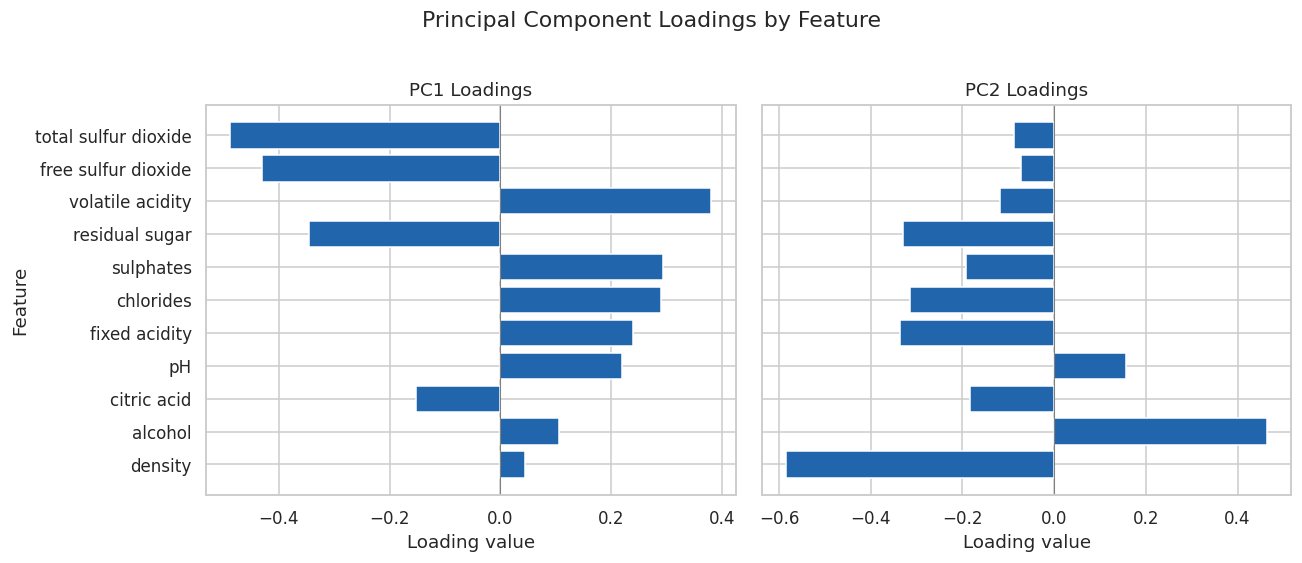

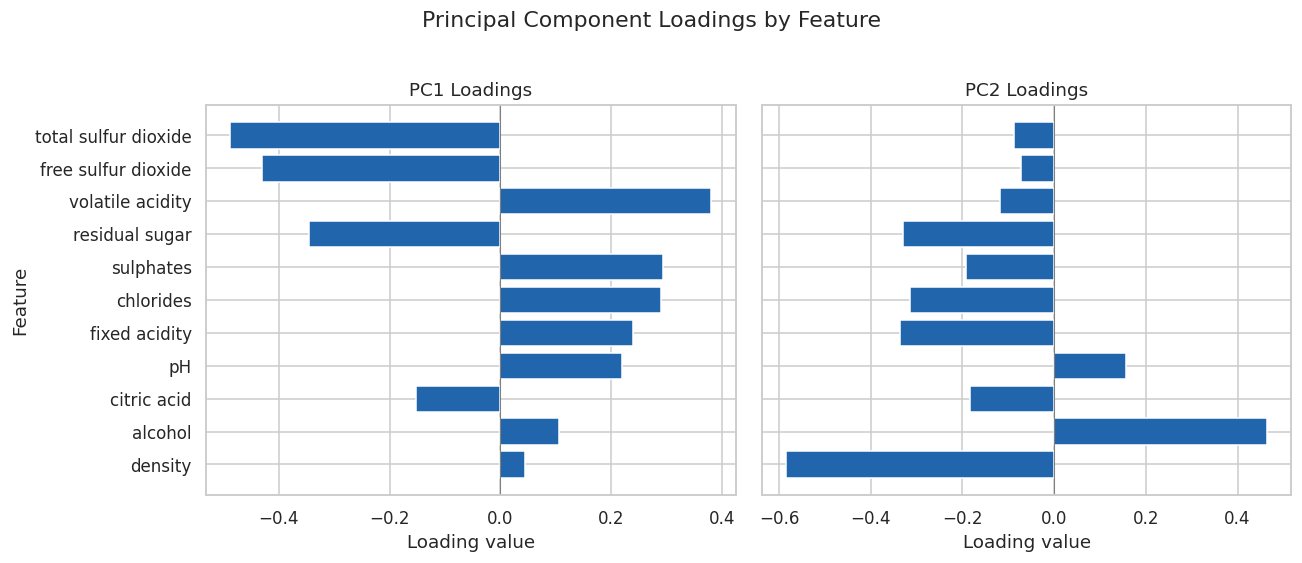

In [18]:
# Visualize loading magnitudes for PC1 and PC2
loadings_long = (
    loadings_df[['PC1', 'PC2']]
    .reset_index(names='feature')
    .melt(id_vars='feature', var_name='component', value_name='loading')
)
loadings_long['abs_loading'] = loadings_long['loading'].abs()
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for ax, component in zip(axes, ['PC1', 'PC2']):
    ordered = loadings_long[loadings_long['component'] == component]
    ordered = ordered.sort_values('abs_loading', ascending=True)
    ax.barh(ordered['feature'], ordered['loading'], color='#2166ac')
    ax.axvline(0, color='grey', linewidth=0.7)
    ax.set_title(f'{component} Loadings')
    ax.set_xlabel('Loading value')
axes[0].set_ylabel('Feature')
fig.suptitle('Principal Component Loadings by Feature', y=1.02)
fig.tight_layout()
fig

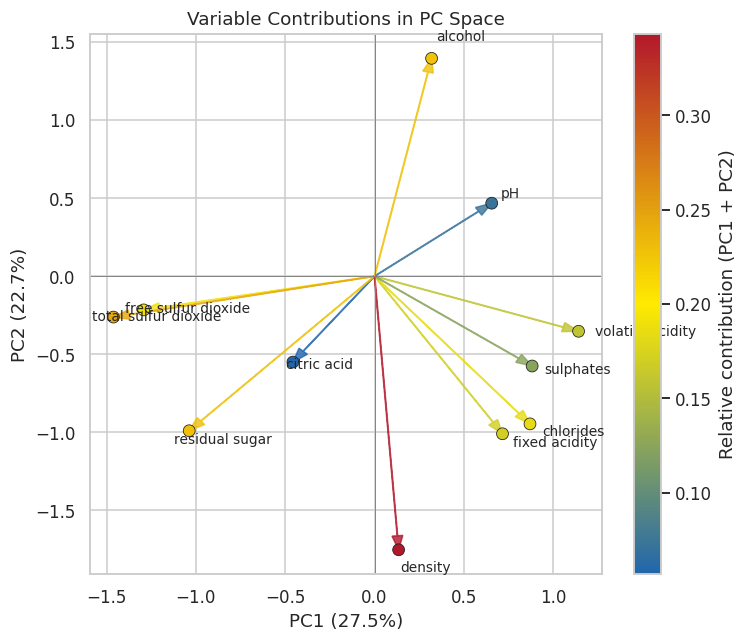

In [19]:
# Biplot-style visualization of PCA variable contributions
from matplotlib.colors import LinearSegmentedColormap, Normalize
loadings_coords = loadings_df[['PC1', 'PC2']].copy()
contrib = (loadings_coords ** 2).sum(axis=1)
cmap = LinearSegmentedColormap.from_list('blue_yellow_red', ['#2166ac', '#ffea00', '#b2182b'])
norm = Normalize(vmin=contrib.min(), vmax=contrib.max())
scale = 3.0  # scale arrows for readability
plt.figure(figsize=(7, 6))
for feature, row in loadings_coords.iterrows():
    color = cmap(norm(contrib[feature]))
    plt.arrow(0, 0, row['PC1'] * scale, row['PC2'] * scale,
              color=color, alpha=0.8, width=0.003, head_width=0.06, length_includes_head=True)
    plt.text(row['PC1'] * scale * 1.08, row['PC2'] * scale * 1.08, feature, fontsize=9)
scatter = plt.scatter(loadings_coords['PC1'] * scale, loadings_coords['PC2'] * scale,
                      c=contrib, cmap=cmap, norm=norm, s=60, edgecolor='k', linewidth=0.5)
plt.xlabel(f'PC1 ({pc1_var:.1f}%)')
plt.ylabel(f'PC2 ({pc2_var:.1f}%)')
plt.title('Variable Contributions in PC Space')
plt.axhline(0, color='grey', lw=0.6)
plt.axvline(0, color='grey', lw=0.6)
cbar = plt.colorbar(scatter)
cbar.set_label('Relative contribution (PC1 + PC2)')
plt.tight_layout()
plt.show()

## Interpreting the principal components
- **PC1 (27.5% of variance)** loads strongly on sulfur dioxide and residual sugar (positive) versus volatile acidity, chlorides and sulphates (negative). White wines tend to sit on the positive side (higher sulfur management), while reds stay negative due to higher volatile acidity and sulphate additions. 
- **PC2 (22.7% of variance)** contrasts density, residual sugar and chlorides (positive) with alcohol content (negative). Sweeter, denser wines—often lower-quality whites—trend upward, while higher-alcohol, lighter wines project downward.
- Quality scores show partial ordering: higher-quality wines concentrate toward the lower-right quadrant (higher alcohol, lower density), echoing that flavor balance and ethanol drive quality more than sulfur dioxide dosage.
- Together the first two PCs deliver ~50% of the variance, meeting the assignment brief for dimensional reduction while preserving interpretable chemistry-driven structure.